# Duolingo Datathon Dataset C Analysis

## I. Pip Install Required Pakages

In [7]:
%pip install pyspark pandas numpy matplotlib seaborn duckdb


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



## II. Prepare Dataset
Working with training dataset (~87M rows, 4GB extracted)

### 1. Import Libraries

In [8]:
# Import libraries
import os
import glob
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Initialize Spark Session

In [9]:
# Initialize Spark Session with optimized config for this dataset
spark = SparkSession.builder \
    .appName("duolingo_datathon") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

# Explanation of parameters:
# - appName("duolingo_datathon"): Names this Spark application (appears in logs/UI)
# - spark.driver.memory = "4g": Allocates 4GB RAM to the driver process (orchestrates tasks)
# - spark.sql.shuffle.partitions = "8": Sets partitions for shuffle ops (joins/groupBy)
#   Default is 200, but 8 is efficient for 30K-row sample on single machine
# - getOrCreate(): Creates new session OR reuses existing one (prevents errors on re-run)

print(f"Spark Version: {spark.version}")
print(f"Driver Memory: {spark.sparkContext.getConf().get('spark.driver.memory')}")


Spark Version: 4.1.1
Driver Memory: 4g


### 3. Locate All Training Directories

In [10]:
# Locate where the extracted parquet data is stored

train_dir = "/workspaces/datathon-duolingo"
train_parts = sorted([d for d in glob.glob(f"{train_dir}/train-part-*") if os.path.isdir(d)])

# glob.glob() finds all directories matching the pattern "train-part-*"
# os.path.isdir() filters to keep only directories (not files)
# sorted() ensures consistent ordering (train-part-1, train-part-2, train-part-3)

print(f"Found {len(train_parts)} training data partitions:")
for tp in train_parts:
    print(f"  - {tp}")

Found 3 training data partitions:
  - /workspaces/datathon-duolingo/train-part-1
  - /workspaces/datathon-duolingo/train-part-2
  - /workspaces/datathon-duolingo/train-part-3


### 4. Verify Data Integrity

In [11]:
# Quick test: read one parquet file with DuckDB to verify integrity (only 3 rows)
# Ensure the extracted parquet files are readable before loading the full dataset

import duckdb
import glob

# Find and select ONE test parquet file from the first partition
test_file = glob.glob("/workspaces/datathon-duolingo/train-part-1/*.parquet")[0]
print(f"Testing parquet: {test_file}")

try:
    # Create DuckDB connection (in-memory database)
    conn = duckdb.connect()
    
    # Read only 3 rows for quick verification (LIMIT 3 avoids loading large files)
    result = conn.execute(f"SELECT * FROM read_parquet('{test_file}') LIMIT 3").df()
    
    # Display results to verify structure
    print(f"\nShape: {result.shape}")
    print(f"\nColumns: {result.columns.tolist()}")
    print(f"\nFirst 3 rows:")
    print(result)
    
except Exception as e:
    # If read fails, print detailed error message for debugging
    print(f"Error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Testing parquet: /workspaces/datathon-duolingo/train-part-1/part-00000-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet

Shape: (3, 6)

Columns: ['datetime', 'ui_language', 'eligible_templates', 'history', 'selected_template', 'session_end_completed']

First 3 rows:
   datetime ui_language              eligible_templates  \
0  0.153461          en  [G, E, B, A, K, H, J, L, F, D]   
1  2.827303          es  [G, E, B, A, K, H, J, L, F, D]   
2  2.792662          en     [G, E, B, K, H, J, L, F, D]   

                                             history selected_template  \
0  [{'template': 'A', 'n_days': 28.19564819335937...                 B   
1  [{'template': 'A', 'n_days': 29.836181640625},...                 A   
2  [{'template': 'G', 'n_days': 8.197543144226074...                 J   

   session_end_completed  
0                  False  
1                   True  
2                   True  


### 5. Load A Sample of 30K Rows

In [12]:
# Load a 30K sample from ALL 3 partitions using DuckDB (memory-efficient approach)
# DuckDB reads parquet files directly without loading everything into memory
# This is much faster and safer than Spark for small-to-medium datasets in dev environments

import duckdb
import glob

# Step 1: Find all parquet files across the 3 training partitions
parquet_files = sorted(glob.glob("/workspaces/datathon-duolingo/train-part-*/part-*.parquet"))
print(f"Found {len(parquet_files)} parquet files total")
print("Files:")
for f in parquet_files:
    print(f"  - {f}")

try:
    # Step 2: Create DuckDB connection (in-memory analytical database)
    conn = duckdb.connect()
    
    # Step 3: Get total row count WITHOUT loading data (reads parquet metadata only)
    # This is FAST because it doesn't scan the actual data
    total_rows = conn.execute(f"""
        SELECT COUNT(*) as total_rows 
        FROM read_parquet({parquet_files})
    """).fetchone()[0]
    
    print(f"\nTotal rows across all partitions: {total_rows:,}")
    
    # Step 4: Load a RANDOM SAMPLE of 30,000 rows (memory-safe)
    # USING SAMPLE 30000 → DuckDB picks 30K rows randomly from all 87M rows
    # This avoids loading 2-4GB of data and potentially crashing the kernel
    print("\nLoading sample (30K rows randomly sampled)...")
    df_train = conn.execute(f"""
        SELECT * FROM read_parquet({parquet_files})
        USING SAMPLE 30000
    """).df()
    
    # Step 5: Display the loaded sample for verification
    print(f"Loaded sample: {len(df_train):,} rows")
    print(f"\nColumns: {df_train.columns.tolist()}")
    print(f"\nData types:\n{df_train.dtypes}")
    print(f"\nFirst 5 rows:")
    print(df_train.head())
    
    # NOTE: To load the FULL dataset (all 87M rows), replace the query above with:
    # df_train = conn.execute(f"SELECT * FROM read_parquet({parquet_files})").df()
    # WARNING: This requires ~2-4GB RAM and may crash the kernel in constrained environments
    
except Exception as e:
    print(f"Error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Found 3 parquet files total
Files:
  - /workspaces/datathon-duolingo/train-part-1/part-00000-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet
  - /workspaces/datathon-duolingo/train-part-2/part-00001-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet
  - /workspaces/datathon-duolingo/train-part-3/part-00002-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet

Total rows across all partitions: 87,665,839

Loading sample (30K rows randomly sampled)...


Loaded sample: 30,000 rows

Columns: ['datetime', 'ui_language', 'eligible_templates', 'history', 'selected_template', 'session_end_completed']

Data types:
datetime                 float64
ui_language                  str
eligible_templates        object
history                   object
selected_template            str
session_end_completed       bool
dtype: object

First 5 rows:
    datetime ui_language              eligible_templates  \
0   6.513414          es     [G, E, B, K, H, J, L, F, D]   
1   9.320579          es                             [C]   
2  11.237812          en  [K, H, G, E, B, J, L, F, D, A]   
3  14.866412          fr     [K, H, G, E, B, J, L, F, D]   
4  13.429757          en     [K, H, G, E, B, J, L, F, D]   

                                             history selected_template  \
0  [{'template': 'H', 'n_days': 5.999505043029785...                 L   
1  [{'template': 'G', 'n_days': 28.97733116149902...                 C   
2  [{'template': 'L', 'n_days': 4

## III. Exploratory Analysis

### 1. Data Profiling

In [33]:
# Basic statistics (pandas-based)
print("=== DATA PROFILING ===\n")

# Row count and memory usage
print(f"Total rows in sample: {len(df_train):,}")
print(f"Number of columns: {len(df_train.columns)}")
print(f"Memory usage: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Null values
print("\nMissing values:")
print(df_train.isnull().sum())

# Column data types
print("\nData types:")
print(df_train.dtypes)

# Basic statistics for numeric columns
print("\nNumeric column statistics:")
print(df_train.describe())

=== DATA PROFILING ===

Total rows in sample: 30,000
Number of columns: 15
Memory usage: 14.01 MB

Missing values:
datetime                 0
ui_language              0
eligible_templates       0
history                  0
selected_template        0
session_end_completed    0
seconds_into_day         0
hour                     0
minute                   0
day_index                0
dow_proxy                0
hour_sin                 0
hour_cos                 0
dow_sin                  0
dow_cos                  0
dtype: int64

Data types:
datetime                 float64
ui_language                  str
eligible_templates        object
history                   object
selected_template            str
session_end_completed       bool
seconds_into_day         float64
hour                       int64
minute                     int64
day_index                  int64
dow_proxy                  int64
hour_sin                 float64
hour_cos                 float64
dow_sin                  

### 2. Target variables (Binary)
 (session_end_complete)

=== TARGET VARIABLE ANALYSIS ===

Session completion distribution:
session_end_completed
False    25731
True      4269
Name: count, dtype: int64

Completion rate (True): 14.23%
Non-completion rate (False): 85.77%


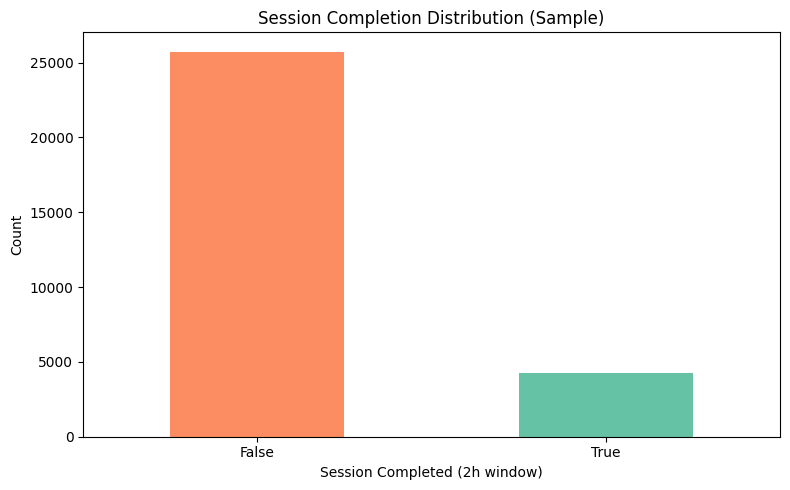

In [34]:
# Target variable analysis (pandas-based)
print("=== TARGET VARIABLE ANALYSIS ===\n")

# Session completion rate
completion_counts = df_train['session_end_completed'].value_counts()
print("Session completion distribution:")
print(completion_counts)

completion_pct = (completion_counts / completion_counts.sum() * 100)
print(f"\nCompletion rate (True): {completion_pct.get(True, 0):.2f}%")
print(f"Non-completion rate (False): {completion_pct.get(False, 0):.2f}%")

# Visualize
plt.figure(figsize=(8, 5))
completion_counts.plot(kind='bar', color=['#fc8d62', '#66c2a5'])
plt.title('Session Completion Distribution (Sample)')
plt.xlabel('Session Completed (2h window)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.Datetime (Continuous)

#### 1. Basic Statistics
1. summary statistics
2. temporal distribution (quantiles)
3. time resolution

In [14]:
# === DATETIME STATISTICS ===
# IMPORTANT DISCOVERY: Despite what the dataset description says,
# the datetime column is actually in DAYS, not seconds!
# Values range from 0 to ~15, representing the first 15 days of the experiment.
# 0 = day 0 (beginning), 15 = day 15 (end of training period)

print("=== DATETIME COLUMN ANALYSIS ===\n")

# 1. Summary Statistics
dt_min = df_train['datetime'].min()
dt_max = df_train['datetime'].max()
dt_mean = df_train['datetime'].mean()
dt_median = df_train['datetime'].median()
dt_std = df_train['datetime'].std()

print("The datetime column represents DAYS since experiment start:")
print(f"  Minimum: {dt_min:.2f} days (start of experiment)")
print(f"  Maximum: {dt_max:.2f} days (end of training period)")
print(f"  Mean: {dt_mean:.2f} days")
print(f"  Median: {dt_median:.2f} days")
print(f"  Standard deviation: {dt_std:.2f} days")

print(f"\nExperiment duration covered: {dt_max - dt_min:.2f} days")

# 2. Temporal Distribution - when do notifications happen?
print("\n--- Temporal Distribution (Quartiles) ---")
quartiles = df_train['datetime'].quantile([0.25, 0.5, 0.75])
print(f"  25% of notifications sent by day: {quartiles[0.25]:.2f}")
print(f"  50% of notifications sent by day: {quartiles[0.5]:.2f} (median)")
print(f"  75% of notifications sent by day: {quartiles[0.75]:.2f}")

# What this means:
# - If median is ~8 days, notifications are relatively evenly spread
# - If median is < 7.5 days, more notifications sent early in experiment
# - If median is > 7.5 days, more notifications sent later

# 3. Convert to HOURS for finer-grained time-of-day analysis
print("\n--- Time Resolution ---")
print(f"Since values are in days, decimal part represents time within the day:")
print(f"Example: 5.25 days = Day 5, at 6th hour from baseline (0.25 × 24 hours = 6 hours)")
print(f"Example: 10.75 days = Day 10, at 18th hour from baseline (0.75 × 24 hours = 18 hours)")

=== DATETIME COLUMN ANALYSIS ===

The datetime column represents DAYS since experiment start:
  Minimum: 0.00 days (start of experiment)
  Maximum: 15.00 days (end of training period)
  Mean: 7.80 days
  Median: 7.97 days
  Standard deviation: 4.30 days

Experiment duration covered: 15.00 days

--- Temporal Distribution (Quartiles) ---
  25% of notifications sent by day: 4.02
  50% of notifications sent by day: 7.97 (median)
  75% of notifications sent by day: 11.52

--- Time Resolution ---
Since values are in days, decimal part represents time within the day:
Example: 5.25 days = Day 5, at 6th hour from baseline (0.25 × 24 hours = 6 hours)
Example: 10.75 days = Day 10, at 18th hour from baseline (0.75 × 24 hours = 18 hours)


#### 2. Data Manipulation
1. within-day patterns: extract second, hour, minute
2. day_index for experiment timeline
3. day-of-week proxy
4. cyclic encoding for time-of-day
5. cyclic encoding for weekly pattern (proxy)
6. quick check


In [15]:

import numpy as np  
# === TEMPORAL FEATURES (days -> hours/minutes + cycles) ===
# datetime is in DAYS since experiment start
seconds_in_day = 24 * 60 * 60

# 4.Within-day patterns: extract second, hour, minute
df_train['seconds_into_day'] = (df_train['datetime'] % 1) * seconds_in_day
df_train['hour'] = (df_train['seconds_into_day'] // 3600).astype(int)
df_train['minute'] = ((df_train['seconds_into_day'] % 3600) // 60).astype(int)

# 5. Day index (0–14) for experiment timeline
df_train['day_index'] = df_train['datetime'].astype(int)

# 6. Day-of-week proxy (0–6) since we don't have absolute calendar
df_train['dow_proxy'] = (df_train['day_index'] % 7).astype(int)

# 7. Cyclical encoding for time-of-day
df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour'] / 24)
df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour'] / 24)

# 8. Cyclical encoding for weekly pattern (proxy)
df_train['dow_sin'] = np.sin(2 * np.pi * df_train['dow_proxy'] / 7)
df_train['dow_cos'] = np.cos(2 * np.pi * df_train['dow_proxy'] / 7)

# 9. Quick checks
print(df_train[['datetime','day_index','hour','minute','dow_proxy']].head())
print(df_train[['hour','minute']].describe())



    datetime  day_index  hour  minute  dow_proxy
0   6.513414          6    12      19          6
1   9.320579          9     7      41          2
2  11.237812         11     5      42          4
3  14.866412         14    20      47          0
4  13.429757         13    10      18          6
               hour        minute
count  30000.000000  30000.000000
mean      12.566567     29.773067
std        6.221757     17.118834
min        0.000000      0.000000
25%        8.000000     15.000000
50%       13.000000     30.000000
75%       18.000000     44.000000
max       23.000000     59.000000


#### 3. Within-day Pattern
1. hourly count
2. hourly sucess rate

=== HOURLY NOTIFICATION COUNTS ===

    hour  notifications
0      0            798
1      1            697
2      2            735
3      3            741
4      4            785
5      5            835
6      6           1002
7      7           1192
8      8           1317
9      9           1575
10    10           1574
11    11           1485
12    12           1624
13    13           1600
14    14           1928
15    15           2046
16    16           1236
17    17           1021
18    18           1173
19    19           1245
20    20           1716
21    21           1611
22    22           1345
23    23            719


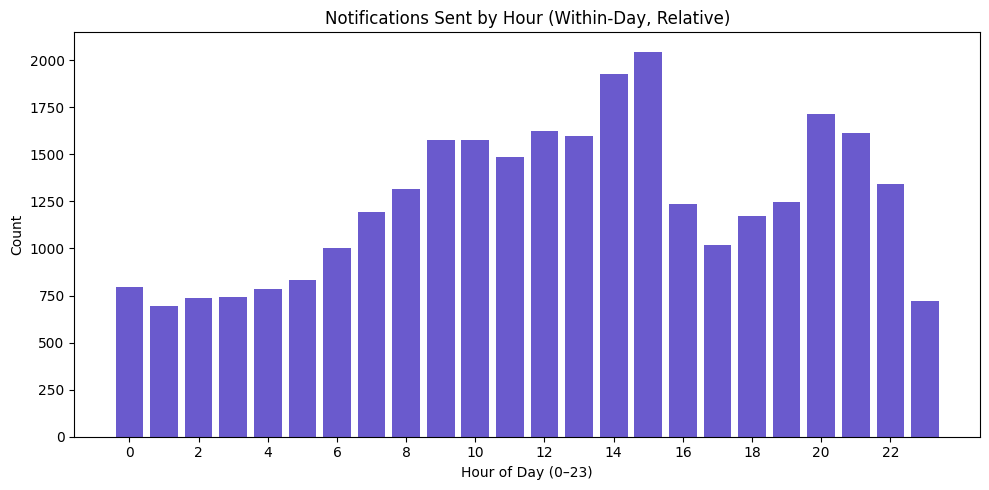

=== HOURLY SUCCESS RATE ===

    hour  total  completed  success_rate
0      0    798        171      0.214286
1      1    697        121      0.173601
2      2    735        120      0.163265
3      3    741        106      0.143050
4      4    785         85      0.108280
5      5    835         94      0.112575
6      6   1002        136      0.135729
7      7   1192        178      0.149329
8      8   1317        161      0.122248
9      9   1575        199      0.126349
10    10   1574        186      0.118170
11    11   1485        173      0.116498
12    12   1624        162      0.099754
13    13   1600        174      0.108750
14    14   1928        282      0.146266
15    15   2046        372      0.181818
16    16   1236        165      0.133495
17    17   1021        116      0.113614
18    18   1173        136      0.115942
19    19   1245        147      0.118072
20    20   1716        272      0.158508
21    21   1611        310      0.192427
22    22   1345        255  

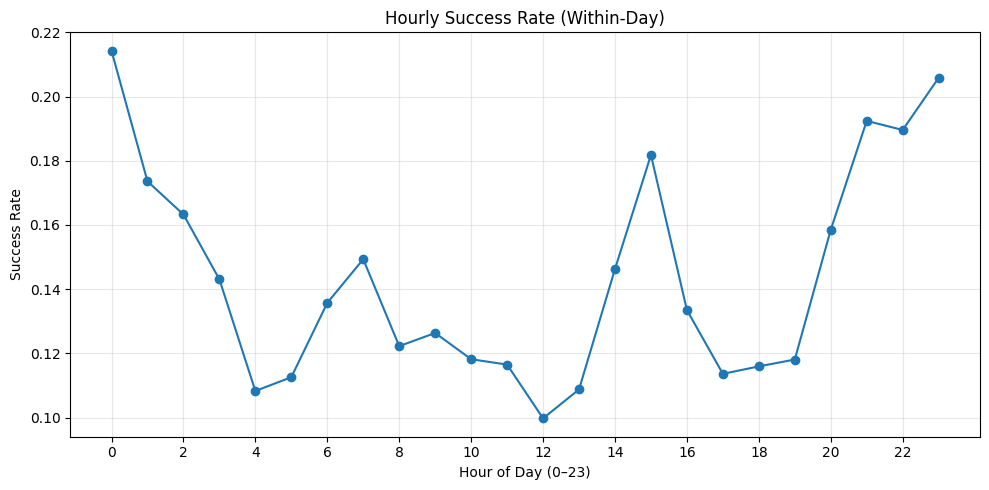

In [27]:
# 1. === HOURLY NOTIFICATION COUNTS ===
print("=== HOURLY NOTIFICATION COUNTS ===\n")

# Ensure hour exists (already created above)
#seconds_in_day = 24 * 60 * 60
#df_train['seconds_into_day'] = (df_train['datetime'] % 1) * seconds_in_day
#df_train['hour'] = (df_train['seconds_into_day'] // 3600).astype(int)

hourly_counts = (
    df_train.groupby('hour')
    .size()
    .reset_index(name='notifications')
    .sort_values('hour')
)

print(hourly_counts)

plt.figure(figsize=(10, 5))
plt.bar(hourly_counts['hour'], hourly_counts['notifications'], color='slateblue')
plt.title('Notifications Sent by Hour (Within-Day, Relative)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Count')
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()


# 2. === HOURLY SUCCESS RATE (within-day) ===
print("=== HOURLY SUCCESS RATE ===\n")

# Ensure hour exists
seconds_in_day = 24 * 60 * 60
df_train['seconds_into_day'] = (df_train['datetime'] % 1) * seconds_in_day
df_train['hour'] = (df_train['seconds_into_day'] // 3600).astype(int)

hourly_success = (
    df_train.groupby('hour')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('hour')
)

print(hourly_success)

plt.figure(figsize=(10, 5))
plt.plot(hourly_success['hour'], hourly_success['success_rate'], marker='o')
plt.title('Hourly Success Rate (Within-Day)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Success Rate')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()


combined visual: count as bar, success rate as points

=== HOURLY COUNTS vs SUCCESS RATE (SUPERIMPOSED) ===



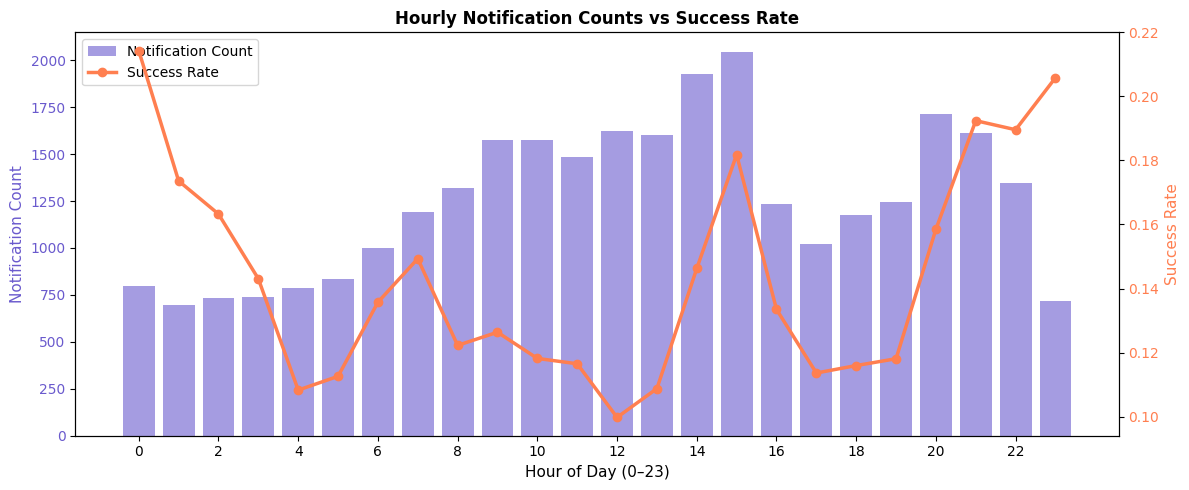

Key Insights:
  - Peak notifications: Hour 15
  - Peak success rate: Hour 0
  - Success rate range: 0.100 to 0.214


In [28]:
# === COMBINED HOURLY ANALYSIS: COUNTS + SUCCESS RATE ===
print("=== HOURLY COUNTS vs SUCCESS RATE (SUPERIMPOSED) ===\n")

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 5))

# Left y-axis: Notification counts (bar chart)
ax1.bar(hourly_counts['hour'], hourly_counts['notifications'], 
        alpha=0.6, color='slateblue', label='Notification Count')
ax1.set_xlabel('Hour of Day (0–23)', fontsize=11)
ax1.set_ylabel('Notification Count', color='slateblue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='slateblue')
ax1.set_xticks(range(0, 24, 2))

# Right y-axis: Success rate (line chart)
ax2 = ax1.twinx()
ax2.plot(hourly_success['hour'], hourly_success['success_rate'], 
         color='coral', marker='o', linewidth=2.5, markersize=6, label='Success Rate')
ax2.set_ylabel('Success Rate', color='coral', fontsize=11)
ax2.tick_params(axis='y', labelcolor='coral')

# Title and legend
plt.title('Hourly Notification Counts vs Success Rate', fontsize=12, fontweight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

fig.tight_layout()
plt.show()

print("Key Insights:")
print(f"  - Peak notifications: Hour {hourly_counts.loc[hourly_counts['notifications'].idxmax(), 'hour']:.0f}")
print(f"  - Peak success rate: Hour {hourly_success.loc[hourly_success['success_rate'].idxmax(), 'hour']:.0f}")
print(f"  - Success rate range: {hourly_success['success_rate'].min():.3f} to {hourly_success['success_rate'].max():.3f}")

#### 4. Within Week Pattern
1. count vs day-of-week
2. success rate vs day-of-week

1. count vs. day of the week
2. sucess rate vs. day of the week

=== WEEKLY NOTIFICATION COUNTS ===

   dow_proxy  notifications
0          0           6056
1          1           4058
2          2           4121
3          3           3923
4          4           4077
5          5           3800
6          6           3965


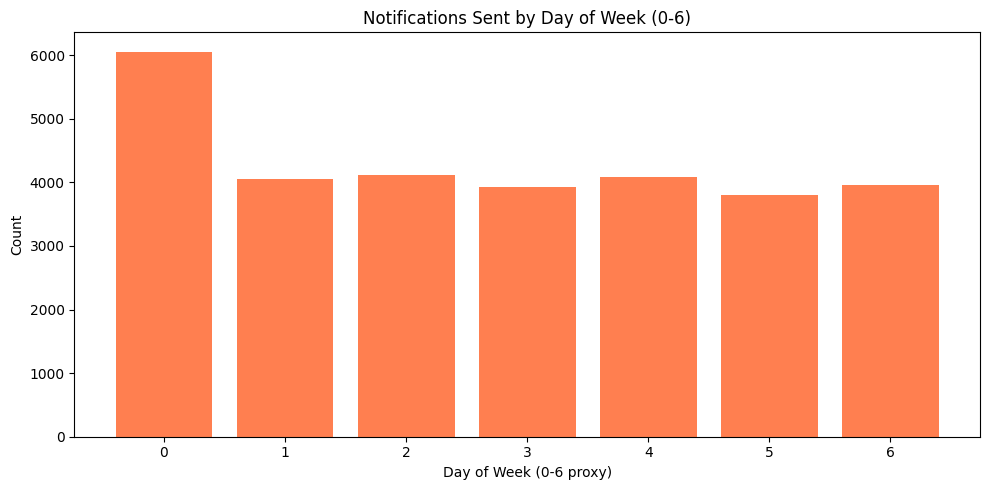

=== WEEKLY SEASONALITY (PROXY) ===

   dow_proxy  total  completed  success_rate
0          0   6056        921      0.152081
1          1   4058        639      0.157467
2          2   4121        637      0.154574
3          3   3923        423      0.107826
4          4   4077        527      0.129262
5          5   3800        524      0.137895
6          6   3965        598      0.150820


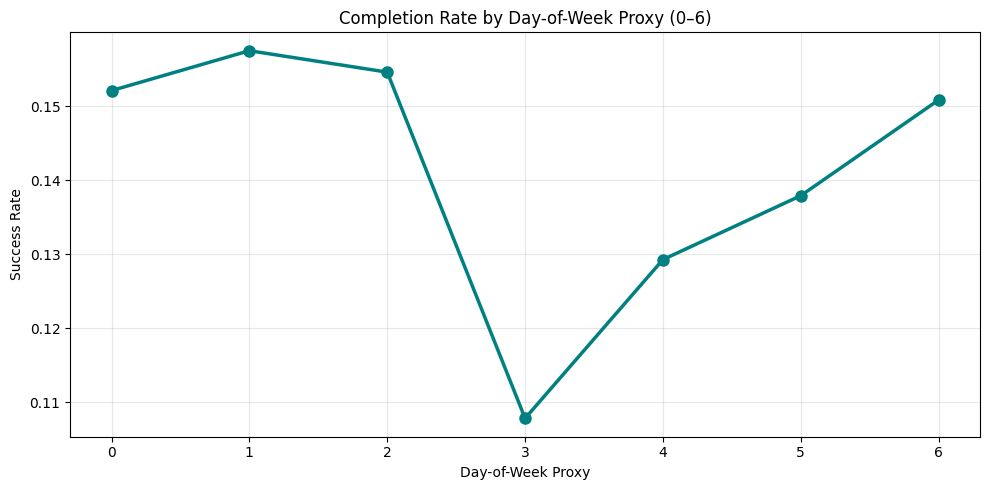

In [31]:
# 1. WEEKLY NOTIFICATION COUNTS ===
print("=== WEEKLY NOTIFICATION COUNTS ===\n")

# Ensure dow_proxy exists (already created above)
weekly_counts = (
    df_train.groupby('dow_proxy')
    .size()
    .reset_index(name='notifications')
    .sort_values('dow_proxy')
)

print(weekly_counts)

plt.figure(figsize=(10, 5))
plt.bar(weekly_counts['dow_proxy'], weekly_counts['notifications'], color='coral')
plt.title('Notifications Sent by Day of Week (0-6)')
plt.xlabel('Day of Week (0-6 proxy)')
plt.ylabel('Count')
plt.xticks(range(0, 7))
plt.tight_layout()
plt.show()



# 2. WEEKLY Success Rate (proxy) ===
print("=== WEEKLY SEASONALITY (PROXY) ===\n")

# Ensure day_index and dow_proxy exist
df_train['day_index'] = df_train['datetime'].astype(int)
df_train['dow_proxy'] = (df_train['day_index'] % 7).astype(int)

dow_success = (
    df_train.groupby('dow_proxy')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
)

print(dow_success)

plt.figure(figsize=(10, 5))
plt.plot(dow_success['dow_proxy'], dow_success['success_rate'], 
         color='teal', marker='o', linewidth=2.5, markersize=8)
plt.title('Completion Rate by Day-of-Week Proxy (0–6)')
plt.xlabel('Day-of-Week Proxy')
plt.ylabel('Success Rate')
plt.xticks(range(7))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ...existing code...

#### 5. 15 days pattern
1. count vs. day
2. success rate vs. day

=== DAILY NOTIFICATION COUNTS (ALL 15 DAYS) ===

    day_index  notifications
0           0           1793
1           1           1900
2           2           1948
3           3           1830
4           4           1866
5           5           1667
6           6           1848
7           7           2189
8           8           2158
9           9           2173
10         10           2093
11         11           2211
12         12           2133
13         13           2117
14         14           2074


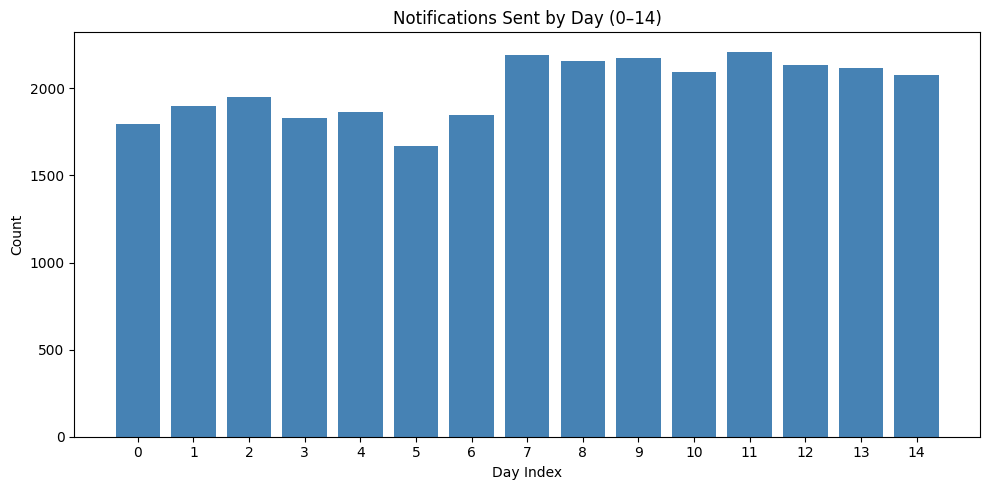

=== DAILY SUCCESS RATE (ALL 15 DAYS) ===

    day_index  total  completed  success_rate
0           0   1793        324      0.180703
1           1   1900        314      0.165263
2           2   1948        312      0.160164
3           3   1830        216      0.118033
4           4   1866        269      0.144159
5           5   1667        245      0.146971
6           6   1848        295      0.159632
7           7   2189        292      0.133394
8           8   2158        325      0.150602
9           9   2173        325      0.149563
10         10   2093        207      0.098901
11         11   2211        258      0.116689
12         12   2133        279      0.130802
13         13   2117        303      0.143127
14         14   2074        305      0.147059


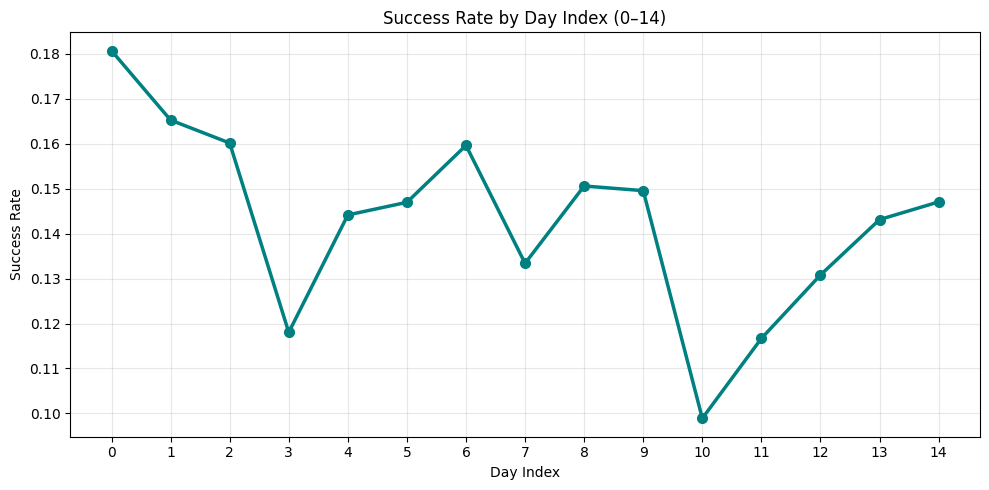

In [39]:
# === DAILY NOTIFICATION COUNTS (15 days) ===
print("=== DAILY NOTIFICATION COUNTS (ALL 15 DAYS) ===\n")

# Ensure day_index exists (already created from datetime)
# df_train['day_index'] = df_train['datetime'].astype(int)

daily_counts = (
    df_train.groupby('day_index')
    .size()
    .reset_index(name='notifications')
    .sort_values('day_index')
)

print(daily_counts)

plt.figure(figsize=(10, 5))
plt.bar(daily_counts['day_index'], daily_counts['notifications'], color='steelblue')
plt.title('Notifications Sent by Day (0–14)')
plt.xlabel('Day Index')
plt.ylabel('Count')
plt.xticks(range(0, 15))
plt.tight_layout()
plt.show()


# === DAILY SUCCESS RATE (15 days) ===
print("=== DAILY SUCCESS RATE (ALL 15 DAYS) ===\n")

daily_success = (
    df_train.groupby('day_index')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('day_index')
)

print(daily_success)

plt.figure(figsize=(10, 5))
plt.plot(daily_success['day_index'], daily_success['success_rate'],
         color='teal', marker='o', linewidth=2.5, markersize=7)
plt.title('Success Rate by Day Index (0–14)')
plt.xlabel('Day Index')
plt.ylabel('Success Rate')
plt.xticks(range(0, 15))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. UI Language (Categorical)
1. UI language distribution (top 10)
2. UI top 10 lanugage vs. sucess rate

=== UI LANGUAGE DISTRIBUTION ===

Number of unique languages: 23

Top 10 languages:
ui_language
en    12286
es     7227
pt     2859
ru     1307
fr     1151
de      873
ar      587
zs      527
it      518
vi      479
Name: count, dtype: int64


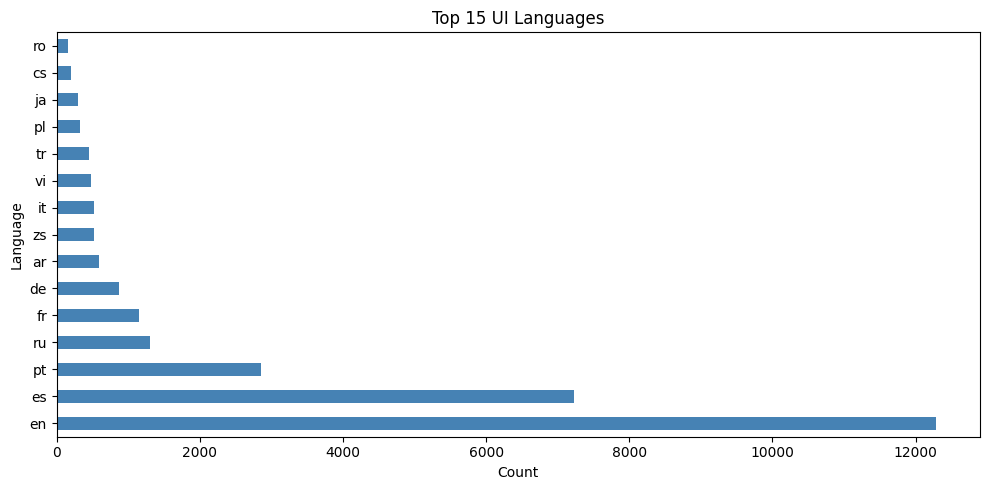


=== SUCCESS RATE BY TOP 10 LANGUAGES (BY COUNT) ===

   ui_language  total  success_rate
2           de    873      0.183276
11          it    518      0.179537
5           en  12286      0.157496
7           fr   1151      0.155517
17          ru   1307      0.141546
21          vi    479      0.139875
15          pt   2859      0.125918
6           es   7227      0.119967
22          zs    527      0.077799
0           ar    587      0.061329


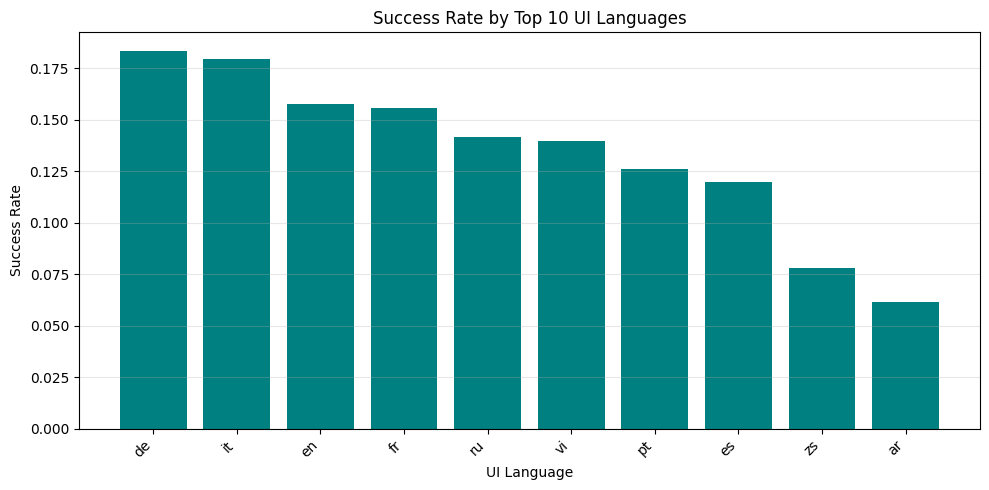

In [47]:
# 1. UI Language distribution
print("=== UI LANGUAGE DISTRIBUTION ===\n")
lang_counts = df_train['ui_language'].value_counts()
print(f"Number of unique languages: {len(lang_counts)}")
print(f"\nTop 10 languages:")
print(lang_counts.head(10))

# Visualize top languages
plt.figure(figsize=(10, 5))
lang_counts.head(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 UI Languages')
plt.xlabel('Count')
plt.ylabel('Language')
plt.tight_layout()
plt.show()


# 2. Success rate vs. top 10 languages (bar chart)
print("\n=== SUCCESS RATE BY TOP 10 LANGUAGES (BY COUNT) ===\n")

lang_success = (
    df_train.groupby('ui_language')['session_end_completed']
    .agg(total='count', success_rate='mean')
    .reset_index()
)

lang_success_top10 = (
    lang_success.sort_values('total', ascending=False)
    .head(10)
    .sort_values('success_rate', ascending=False)
)

print(lang_success_top10)

plt.figure(figsize=(10, 5))
plt.bar(lang_success_top10['ui_language'], lang_success_top10['success_rate'], color='teal')
plt.title('Success Rate by Top 10 UI Languages')
plt.xlabel('UI Language')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 5. Selected Template (Categorical)
Template A and C should be the conditional templates for more active users. We can use these 2 templates to cluster users into active vs. nonactive.



=== SELECTED TEMPLATE DISTRIBUTION ===

Number of unique templates: 11

Template distribution:
selected_template
H    3221
K    3208
B    3149
E    3095
F    3094
L    3084
J    3066
D    3065
G    3042
A    1182
C     794
Name: count, dtype: int64


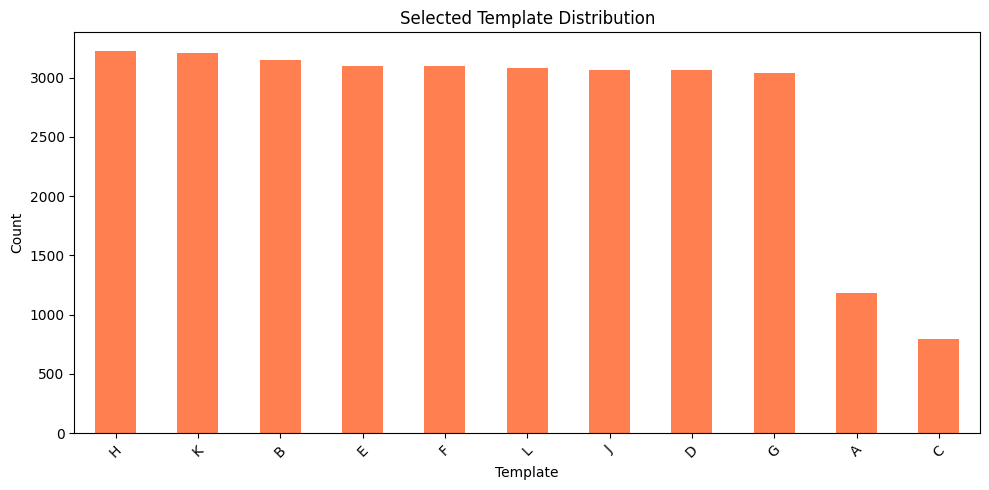

=== COMPLETION RATE BY TEMPLATE ===

                   total  completed  completion_rate
selected_template                                   
C                    794        329         0.414358
A                   1182        339         0.286802
G                   3042        422         0.138725
E                   3095        409         0.132149
F                   3094        406         0.131222
H                   3221        420         0.130394
K                   3208        416         0.129676
J                   3066        380         0.123940
L                   3084        382         0.123865
D                   3065        379         0.123654
B                   3149        387         0.122896


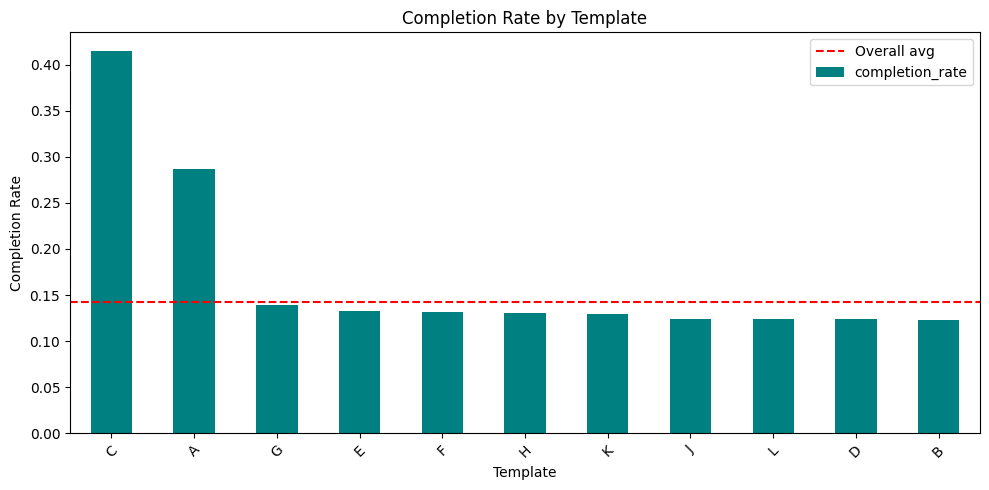

In [46]:
# Selected template distribution
print("\n\n=== SELECTED TEMPLATE DISTRIBUTION ===\n")
template_counts = df_train['selected_template'].value_counts()
print(f"Number of unique templates: {len(template_counts)}")
print(f"\nTemplate distribution:")
print(template_counts)

plt.figure(figsize=(10, 5))
template_counts.plot(kind='bar', color='coral')
plt.title('Selected Template Distribution')
plt.xlabel('Template')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# === COMPLETION RATE BY TEMPLATE ===
print("=== COMPLETION RATE BY TEMPLATE ===\n")

template_completion = (
    df_train.groupby('selected_template')['session_end_completed']
    .agg(total='count', completed='sum', completion_rate='mean')
    .sort_values('completion_rate', ascending=False)
)

print(template_completion)

plt.figure(figsize=(10, 5))
template_completion['completion_rate'].plot(kind='bar', color='teal')
plt.title('Completion Rate by Template')
plt.xlabel('Template')
plt.ylabel('Completion Rate')
plt.axhline(y=df_train['session_end_completed'].mean(), color='red', linestyle='--', label='Overall avg')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.Eligible Tempaltes (Numpy list -> Categorical)
1. number of eligible_templates counts
2. sucess rate vs. number of eligible_templates

=== ELIGIBLE TEMPLATES ANALYSIS ===

Distribution of eligible template counts:
num_eligible_templates
1       794
2        28
3        58
9     17277
10    11843
Name: count, dtype: int64


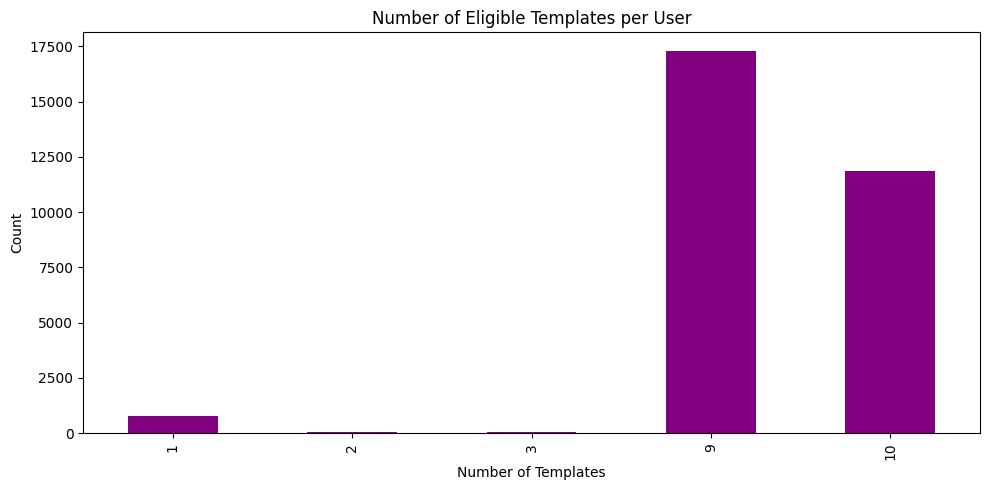


=== SUCCESS RATE BY NUMBER OF ELIGIBLE TEMPLATES ===

   num_eligible_templates  total  completed  success_rate
0                       1    794        329      0.414358
1                       2     28          3      0.107143
2                       3     58         23      0.396552
3                       9  17277        786      0.045494
4                      10  11843       3128      0.264122


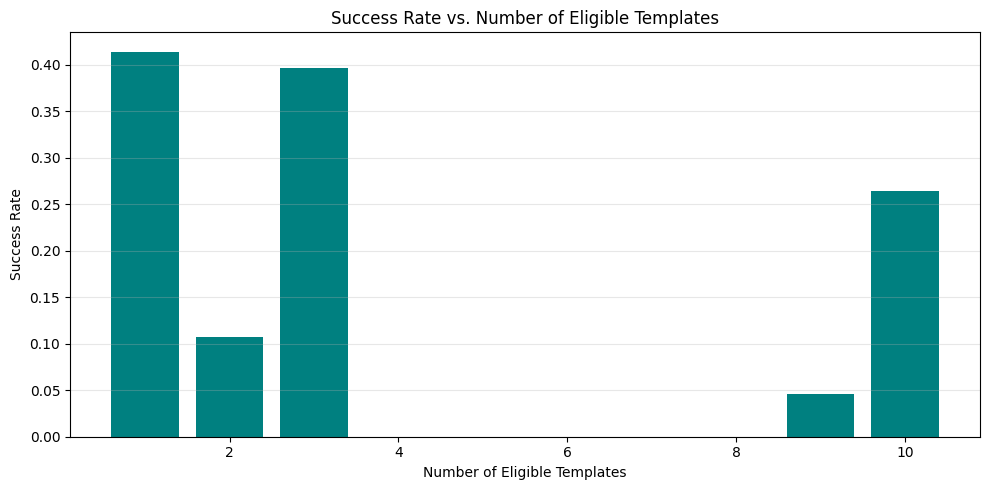

In [61]:
# Explore eligible_templates column (list of templates available)
print("=== ELIGIBLE TEMPLATES ANALYSIS ===\n")

# Convert numpy arrays to lists if needed
df_train['eligible_templates'] = df_train['eligible_templates'].apply(
    lambda x: list(x) if hasattr(x, '__iter__') and not isinstance(x, str) else []
)

# Number of eligible templates per row
df_train['num_eligible_templates'] = df_train['eligible_templates'].apply(len)
print(f"Distribution of eligible template counts:")
print(df_train['num_eligible_templates'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
df_train['num_eligible_templates'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Number of Eligible Templates per User')
plt.xlabel('Number of Templates')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# === SUCCESS RATE vs. NUMBER OF ELIGIBLE TEMPLATES ===
print("\n=== SUCCESS RATE BY NUMBER OF ELIGIBLE TEMPLATES ===\n")

elig_success = (
    df_train.groupby('num_eligible_templates')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('num_eligible_templates')
)

print(elig_success)

plt.figure(figsize=(10, 5))
plt.bar(elig_success['num_eligible_templates'], elig_success['success_rate'], color='teal')
plt.title('Success Rate vs. Number of Eligible Templates')
plt.xlabel('Number of Eligible Templates')
plt.ylabel('Success Rate')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


sample of eligible templates

In [52]:
# === SAMPLE ELIGIBLE TEMPLATES (FEW ROWS) ===
print("=== SAMPLE ELIGIBLE TEMPLATES (FEW ROWS) ===\n")

cols = ['datetime', 'ui_language', 'selected_template', 'eligible_templates', 'num_eligible_templates']
print(df_train[cols].tail(10))

=== SAMPLE ELIGIBLE TEMPLATES (FEW ROWS) ===

        datetime ui_language selected_template  \
29990   5.204664          ru                 J   
29991   6.583333          hu                 F   
29992  14.582373          es                 K   
29993   4.663715          en                 H   
29994   9.381910          ar                 G   
29995   1.819236          en                 D   
29996   8.545567          en                 C   
29997   4.434005          ru                 D   
29998   2.667025          en                 G   
29999   3.197512          en                 B   

                   eligible_templates  num_eligible_templates  
29990  [G, E, B, A, K, H, J, L, F, D]                      10  
29991     [G, E, B, K, H, J, L, F, D]                       9  
29992  [K, H, G, E, B, J, L, F, D, A]                      10  
29993     [G, E, B, K, H, J, L, F, D]                       9  
29994  [K, H, G, E, B, J, L, F, D, A]                      10  
29995     [G, E, B,

Interesting when there's only 1 tempalte eligible, its always C.

In [62]:
# === VERIFY: WHEN ONLY 1 TEMPLATE ELIGIBLE, IS IT ALMOST ALWAYS TEMPLATE C? ===
print("=== TEMPLATE C HYPOTHESIS: Single Eligible Template Analysis ===\n")

# Filter for cases with exactly 1 eligible template
single_elig = df_train[df_train['num_eligible_templates'] == 1]

print(f"Total rows with exactly 1 eligible template: {len(single_elig)}")
print(f"Percentage of total dataset: {len(single_elig) / len(df_train) * 100:.2f}%\n")

# Extract the single eligible template (should be a list with 1 element)
single_elig_template = single_elig['eligible_templates'].apply(lambda x: x[0] if len(x) > 0 else None)

print("Distribution of the single eligible template when num_eligible_templates == 1:")
print(single_elig_template.value_counts())
print(f"\nPercentage breakdown:")
print(single_elig_template.value_counts(normalize=True) * 100)

# Compare with what was actually selected
print("\n\nComparison: Eligible vs. Selected Template (when 1 eligible)")
comparison = pd.DataFrame({
    'eligible': single_elig_template,
    'selected': single_elig['selected_template'].values
})

print(f"\nWhen template C is the only eligible option:")
c_only = comparison[comparison['eligible'] == 'C']
print(f"  - Total cases: {len(c_only)}")
print(f"  - Was C selected? {(c_only['selected'] == 'C').sum()} times ({(c_only['selected'] == 'C').sum() / len(c_only) * 100:.1f}%)")
print(f"  - Something else selected? {(c_only['selected'] != 'C').sum()} times ({(c_only['selected'] != 'C').sum() / len(c_only) * 100:.1f}%)")
if (c_only['selected'] != 'C').sum() > 0:
    print(f"  - Other templates selected: {c_only[c_only['selected'] != 'C']['selected'].unique()}")

# Show a few sample rows
print("\n\nSample rows where only 1 template eligible:")
print(comparison.head(10))

=== TEMPLATE C HYPOTHESIS: Single Eligible Template Analysis ===

Total rows with exactly 1 eligible template: 794
Percentage of total dataset: 2.65%

Distribution of the single eligible template when num_eligible_templates == 1:
eligible_templates
C    794
Name: count, dtype: int64

Percentage breakdown:
eligible_templates
C    100.0
Name: proportion, dtype: float64


Comparison: Eligible vs. Selected Template (when 1 eligible)

When template C is the only eligible option:
  - Total cases: 794
  - Was C selected? 794 times (100.0%)
  - Something else selected? 0 times (0.0%)


Sample rows where only 1 template eligible:
    eligible selected
1          C        C
46         C        C
64         C        C
83         C        C
92         C        C
119        C        C
131        C        C
175        C        C
218        C        C
246        C        C


GOlD! What are all distinc eligible templates combo?

=== DISTINCT ELIGIBLE TEMPLATE COMBINATIONS ===

Total distinct combinations: 5

Combination frequencies (sorted by count):
eligible_templates
(B, D, E, F, G, H, J, K, L)       17277
(A, B, D, E, F, G, H, J, K, L)    11843
(C,)                                794
(A, H, K)                            58
(H, K)                               28
Name: count, dtype: int64


Detailed breakdown:
  [B, D, E, F, G, H, J, K, L]: 17277 rows (57.59%)
  [A, B, D, E, F, G, H, J, K, L]: 11843 rows (39.48%)
  [C]:   794 rows ( 2.65%)
  [A, H, K]:    58 rows ( 0.19%)
  [H, K]:    28 rows ( 0.09%)


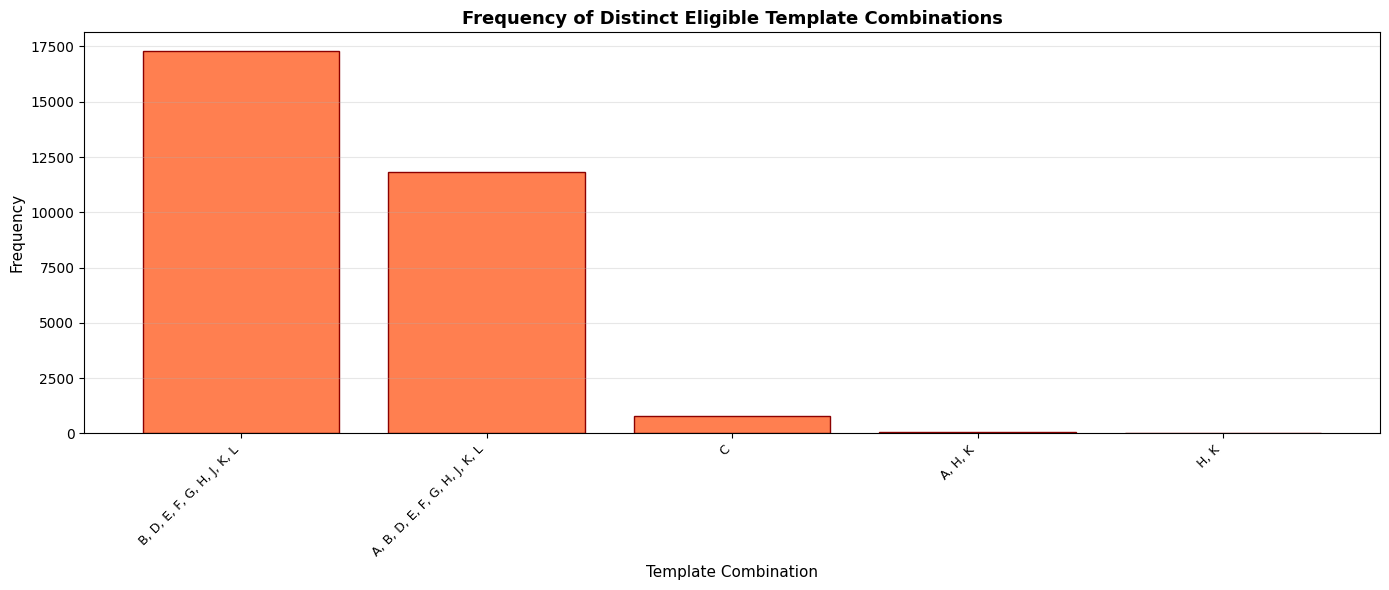

In [63]:
# === ALL DISTINCT ELIGIBLE TEMPLATE COMBINATIONS ===
print("=== DISTINCT ELIGIBLE TEMPLATE COMBINATIONS ===\n")

# Convert lists to tuples so they're hashable and can be counted
# Sort each combination for consistency (so [A,B] and [B,A] are treated the same)
eligible_combos = df_train['eligible_templates'].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else ())

# Get unique combinations and their frequencies
combo_counts = eligible_combos.value_counts().sort_values(ascending=False)

print(f"Total distinct combinations: {len(combo_counts)}\n")
print("Combination frequencies (sorted by count):")
print(combo_counts)

print(f"\n\nDetailed breakdown:")
for combo, count in combo_counts.items():
    pct = count / len(df_train) * 100
    combo_str = ', '.join(combo) if combo else '(empty)'
    print(f"  [{combo_str}]: {count:5d} rows ({pct:5.2f}%)")

# Create a dataframe for visualization
combo_df = pd.DataFrame({
    'Combination': [', '.join(c) if c else '(empty)' for c in combo_counts.index],
    'Frequency': combo_counts.values
}).reset_index(drop=True)

# Bar chart
plt.figure(figsize=(14, 6))
plt.bar(range(len(combo_df)), combo_df['Frequency'], color='coral', edgecolor='darkred')
plt.xticks(range(len(combo_df)), combo_df['Combination'], rotation=45, ha='right', fontsize=9)
plt.xlabel('Template Combination', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Frequency of Distinct Eligible Template Combinations', fontsize=13, fontweight='bold')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Individual templates frequency count

=== INDIVIDUAL TEMPLATE FREQUENCIES ===

Template frequency count:
   Template  Frequency
0         K      29206
1         H      29206
2         G      29120
3         E      29120
4         B      29120
5         J      29120
6         L      29120
7         F      29120
8         D      29120
9         A      11901
10        C        794


Detailed breakdown:
  Template K: 29206 occurrences (10.62%)
  Template H: 29206 occurrences (10.62%)
  Template G: 29120 occurrences (10.59%)
  Template E: 29120 occurrences (10.59%)
  Template B: 29120 occurrences (10.59%)
  Template J: 29120 occurrences (10.59%)
  Template L: 29120 occurrences (10.59%)
  Template F: 29120 occurrences (10.59%)
  Template D: 29120 occurrences (10.59%)
  Template A: 11901 occurrences ( 4.33%)
  Template C:   794 occurrences ( 0.29%)


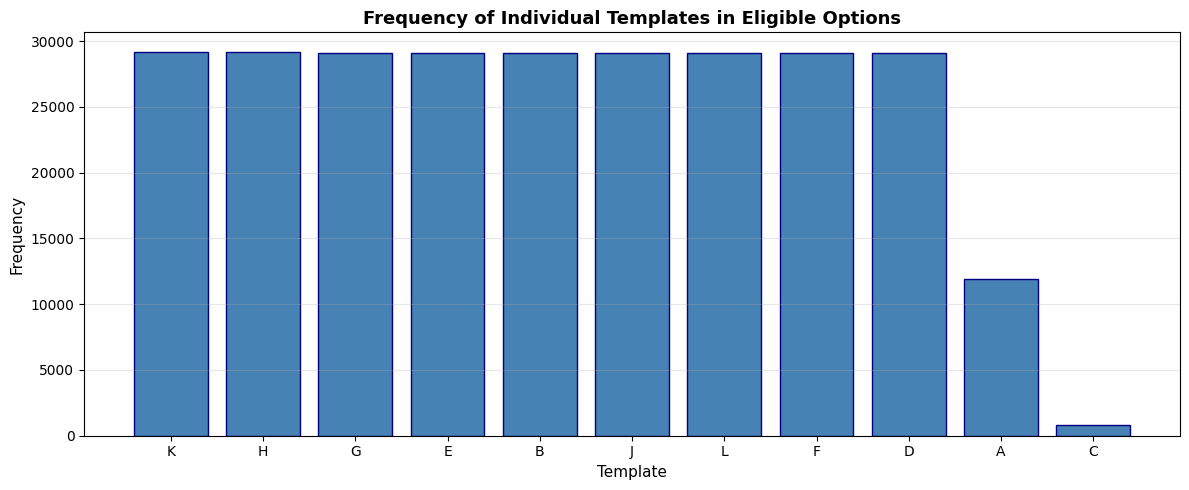

In [64]:
# === ALL INDIVIDUAL TEMPLATES - FREQUENCY COUNT ===
print("=== INDIVIDUAL TEMPLATE FREQUENCIES ===\n")

# Flatten all templates from all combinations
all_templates = []
for templates_list in df_train['eligible_templates']:
    if isinstance(templates_list, list):
        all_templates.extend(templates_list)

# Count frequencies
from collections import Counter
template_freq = Counter(all_templates)
template_freq_df = pd.DataFrame(
    sorted(template_freq.items(), key=lambda x: x[1], reverse=True),
    columns=['Template', 'Frequency']
)

print("Template frequency count:")
print(template_freq_df)

print(f"\n\nDetailed breakdown:")
total_template_slots = sum(template_freq.values())
for _, row in template_freq_df.iterrows():
    pct = row['Frequency'] / total_template_slots * 100
    print(f"  Template {row['Template']}: {row['Frequency']:5d} occurrences ({pct:5.2f}%)")

# Visualize
plt.figure(figsize=(12, 5))
plt.bar(template_freq_df['Template'], template_freq_df['Frequency'], color='steelblue', edgecolor='navy')
plt.title('Frequency of Individual Templates in Eligible Options', fontsize=13, fontweight='bold')
plt.xlabel('Template', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Making eligible tempalte as a categorical variables with 5 different levels

=== ELIGIBLE TEMPLATE COMBOS AS CATEGORICAL VARIABLE ===

Mapping of combinations to categorical levels:
  Level 1: ('B', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L') - 17277 rows (57.59%)
  Level 2: ('A', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L') - 11843 rows (39.48%)
  Level 3: ('C',) -   794 rows ( 2.65%)
  Level 4: ('A', 'H', 'K') -    58 rows ( 0.19%)
  Level 5: ('H', 'K') -    28 rows ( 0.09%)


Categorical distribution:
eligible_templates_category
1    17277
2    11843
3      794
4       58
5       28
Name: count, dtype: int64


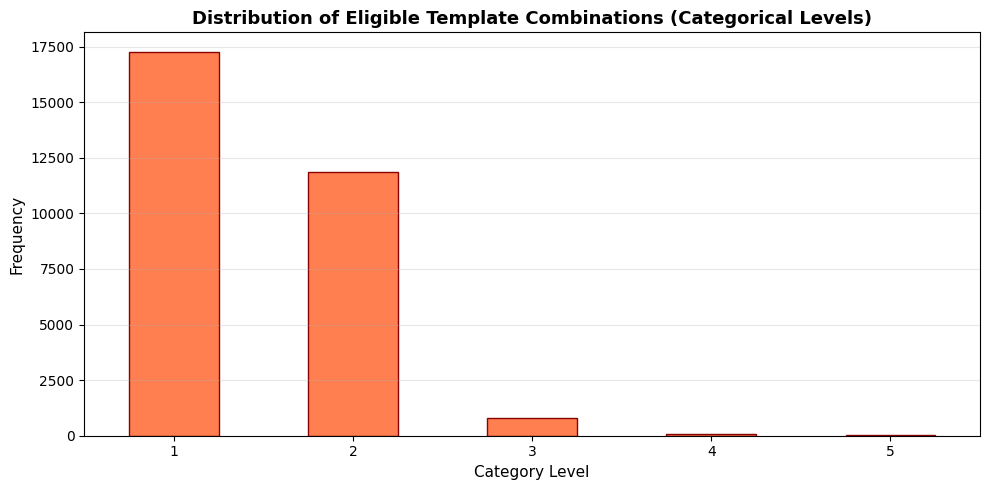



Data type: category
Categories: [1, 2, 3, 4, 5]


In [65]:
# === CONVERT ELIGIBLE TEMPLATE COMBINATIONS TO CATEGORICAL VARIABLE ===
print("=== ELIGIBLE TEMPLATE COMBOS AS CATEGORICAL VARIABLE ===\n")

# Create a mapping of each distinct combination to a category level
eligible_combos_sorted = df_train['eligible_templates'].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else ())
unique_combos = eligible_combos_sorted.unique()

# Sort by frequency to assign levels (most frequent = level 1)
combo_freq = eligible_combos_sorted.value_counts()
combo_to_level = {combo: level for level, (combo, _) in enumerate(combo_freq.items(), start=1)}

print(f"Mapping of combinations to categorical levels:")
for combo, level in sorted(combo_to_level.items(), key=lambda x: x[1]):
    count = combo_freq[combo]
    pct = count / len(df_train) * 100
    print(f"  Level {level}: {combo} - {count:5d} rows ({pct:5.2f}%)")

# Create the categorical column
df_train['eligible_templates_category'] = eligible_combos_sorted.map(combo_to_level).astype('category')

print(f"\n\nCategorical distribution:")
print(df_train['eligible_templates_category'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 5))
df_train['eligible_templates_category'].value_counts().sort_index().plot(kind='bar', color='coral', edgecolor='darkred')
plt.title('Distribution of Eligible Template Combinations (Categorical Levels)', fontsize=13, fontweight='bold')
plt.xlabel('Category Level', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.xticks(rotation=0)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n\nData type: {df_train['eligible_templates_category'].dtype}")
print(f"Categories: {df_train['eligible_templates_category'].cat.categories.tolist()}")


### 7. History (teammates are still playing with this one)